




# Projet Fil Rouge 2023 : Reconnaissance de commandes audio


**Noms :**

**Prénoms :**

**Nom du binôme :**




Ces 12 séances de TP vont vous permettre de tester l'algorithme de programmation dynamique vu en CTD puis de réaliser la mise en oeuvre d'un système de reconnaissance audio de mots isolés (constituant des
commandes pour les drones).

<img src="./DroneJS.JPG" width="600" height="500">



Ces séances se décomposent en ces parties : 
- Partie I : Prétraitement des données 
- Partie II : Sélection de variables et pénalisation
- Partie III : Classification par méthodes à noyau 
- Partie IV : Apprentissage par ensemble : Adaboost, gradient boosting
- Partie V : Classification par réseaux de neurones
- Partie VI : Votre étude




In [41]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import math
import numpy.random as rnd
import seaborn as sns
import librosa
from os import listdir
from os.path import isfile, join
import glob
import re

from sklearn.preprocessing import StandardScaler

# to hide warning 
import warnings
warnings.filterwarnings('ignore')

# Preprocessing

Sur l'espace moodle, vous trouverez un dossier d'enregistrements audio de mots de commandes pour un drone quadricoptère constitués de plusieurs locuteurs masculins (notés M01..M13) et locutrice féminines (F01..F05) pour quelques commandes. 


In [42]:
data = [] 
label = [] 
genres = []
min_duration = None
words = ['avance','recule','tournegauche']
list_genres = ['M', 'F']

for file_name in glob.glob('FichierTest/*.wav'):
    record = librosa.load(file_name)[0]
    data.append(record)
    # Computation of the minimal size of recordings
    if min_duration is None or record.shape[0] < min_duration:
        min_duration = record.shape[0] 
    
    # Creation of the vector of label
    for i, word in enumerate(words):
        if re.search(word, file_name):
            label.append(i)

    # Creation of the vector of label
    for i, genre in enumerate(list_genres):
        if re.search(genre, file_name[12:]): # 12 is for ignoring "FichierTest/"
            genres.append(genre)

fs = librosa.load(file_name)[1] # Sampling frequency
genres = np.array(genres)
print(f'The smallest record contains {min_duration} samples, and the sample frequency is {fs} Hz')

The smallest record contains 18522 samples, and the sample frequency is 22050 Hz


### We trim the recordings to isolate the word and have identical durations
The smallest record contains 18 522 samples. We are going to cut all recordings to be of this size.

In [43]:
def trim(record): # rendre la taille des données unique
    half_duration = 18522//2

    # First, we compute the barycenter of energy along time. We interpret it as the moment when the word appears
    barycenter = int(np.floor(np.multiply(np.power(record,2),np.arange(0,record.shape[0],1)).sum()/np.power(record,2).sum()))

    # Second, we adjust the barycenter to be in the index range
    if barycenter-half_duration < 0:
        barycenter += half_duration-barycenter
    if barycenter+half_duration >= record.shape[0]:
        barycenter -= barycenter+half_duration - record.shape[0]
    
    # Finally, we trim the recording around the barycenter 
    return record[barycenter-half_duration:barycenter+half_duration]

In [44]:
X = np.empty((len(data),min_duration))  # taille 54, 18522
for i in range(len(data)):
    X[i,:] = trim(data[i])

y = np.array(label)
print(f'Shape of inputs X is {X.shape} and size of targets class is {y.shape}')

Shape of inputs X is (54, 18522) and size of targets class is (54,)


In [45]:
X_raw = X

### Spectral representation

1. Apply a Fourrier transform on the signals in $X$ using the function fft of scipy. Explain why the resulting dimension is too large to apply logistic regression.
 Hyperplan sur 1800 varaibles, on a de l'overfitting

2. Let $\hat{X}$ be the fourier transform of $X$. Apply a PCA on $|\hat{X}|$ and plot the total explained variance in function of the numer of components.

In [46]:
from scipy import signal
from scipy.fft import fft
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [47]:
X_fft = fft(X)

Hyperplan sur 1800 variables, on a de l'overfitting.

In [48]:
# X_pca = PCA().fit(np.abs(X_fft))
# X_var = X_pca.explained_variance_ratio_

In [49]:
# X_var_sum = [np.sum(X_var[:i+1]) for i in range(len(X_var))]

In [50]:
# plt.bar(list(range(1, len(X_var_sum)+1)), X_var_sum)

In [51]:
pca = PCA()
pca.fit(np.abs(X_fft))

PCA()

In [52]:
pca.explained_variance_ratio_

array([3.24475740e-01, 1.33758981e-01, 6.55851765e-02, 5.96427610e-02,
       4.34533845e-02, 3.65551217e-02, 3.47280931e-02, 3.21609069e-02,
       2.86073999e-02, 2.56760097e-02, 2.18579698e-02, 1.85952148e-02,
       1.79136137e-02, 1.63518860e-02, 1.46501801e-02, 1.13567143e-02,
       1.06218259e-02, 1.01920479e-02, 9.78307746e-03, 7.60260295e-03,
       6.68985434e-03, 5.83740735e-03, 5.23145808e-03, 5.10167893e-03,
       4.81029841e-03, 4.24574954e-03, 3.94200797e-03, 3.43497133e-03,
       3.11545530e-03, 3.02673964e-03, 2.73692518e-03, 2.63706852e-03,
       2.38762995e-03, 2.28072280e-03, 2.11412042e-03, 1.83228360e-03,
       1.78495556e-03, 1.65026725e-03, 1.54217222e-03, 1.34423433e-03,
       1.29700123e-03, 1.15296704e-03, 1.10518710e-03, 1.07662685e-03,
       9.69908335e-04, 9.27483709e-04, 8.23070940e-04, 7.38631259e-04,
       7.04414274e-04, 6.18837891e-04, 5.31366663e-04, 4.44730046e-04,
       2.95066288e-04, 4.00717397e-31])

3. Apply a Short Term Fourier Transform on $X$. What are the dimension of stft $\hat{X}[t,f]$?
on a besoin des fenêtres, et on applique fft sur ce fenêtre

convolution avec f de basse fréquence nous permettre de capturer les petites fréquences

4. Make 2 subplots (3x3) of the stft (as images with function .imshow()) with three instances of each words, one for male and one for female 

In [53]:
X

array([[ 1.03367704e-04,  2.15590248e-04,  9.61700862e-05, ...,
         4.34567279e-04, -2.65169801e-04, -6.35556004e-04],
       [-8.58392450e-04, -1.14646566e-03, -1.83326437e-03, ...,
        -9.06565925e-04, -7.94830266e-04, -8.86228750e-04],
       [-8.50790006e-04, -7.88065779e-04, -3.54760734e-04, ...,
         6.68462962e-05,  1.07807573e-04, -2.36131382e-04],
       ...,
       [ 4.14384849e-05,  9.68790337e-05,  1.70709347e-04, ...,
        -1.57027598e-03, -2.79719569e-03, -4.04728064e-03],
       [ 4.60200477e-04,  4.77378548e-04,  2.82521534e-04, ...,
        -6.97023002e-04, -5.56244398e-04, -6.00787869e-04],
       [ 1.57168630e-04, -4.77631729e-05, -7.08894877e-05, ...,
        -1.77352678e-03, -1.82752323e-03, -1.14755600e-03]])

(127, 147)


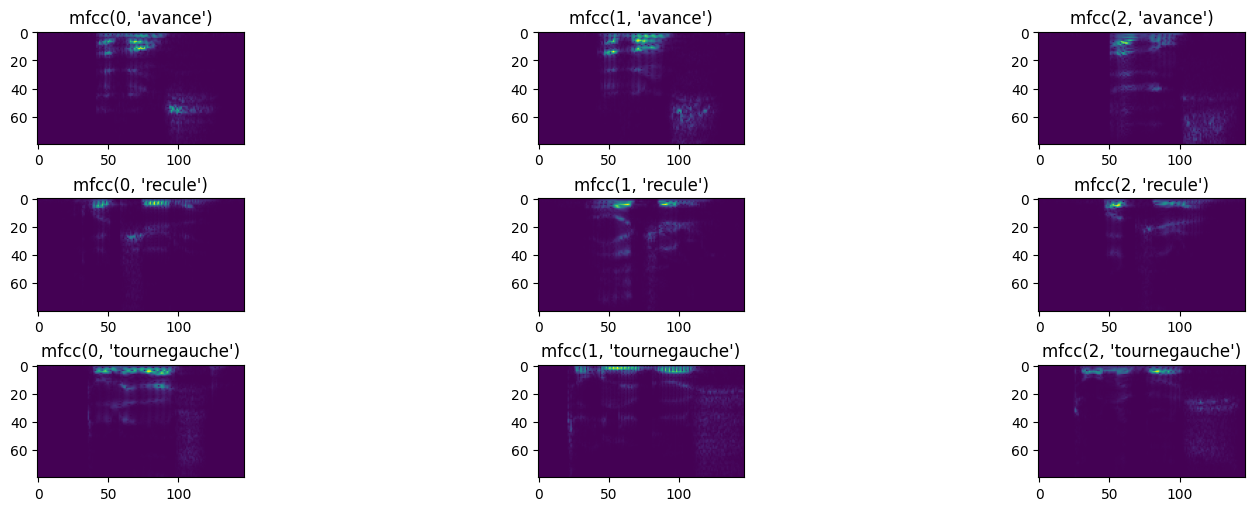

In [54]:
nperseg = 253 # nombre d'échantillon d'un fenêtre auquel on applique fft

# delta w * deltat >= 1/2 (égalité d'Heseinberg) : plus on est précis au temps, moins on est précis en fréquence

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(15,5))
for i,word in enumerate(words):
    for instance in range(3):

        record = X[(y==i) & (genres == 'M')][instance]
        f, t, Zxx = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        axs[i,instance].imshow(np.absolute(Zxx[:80]))
        axs[i,instance].set_title(f'mfcc{instance,word}')

        
print(Zxx.shape)
plt.show()

(201, 94)


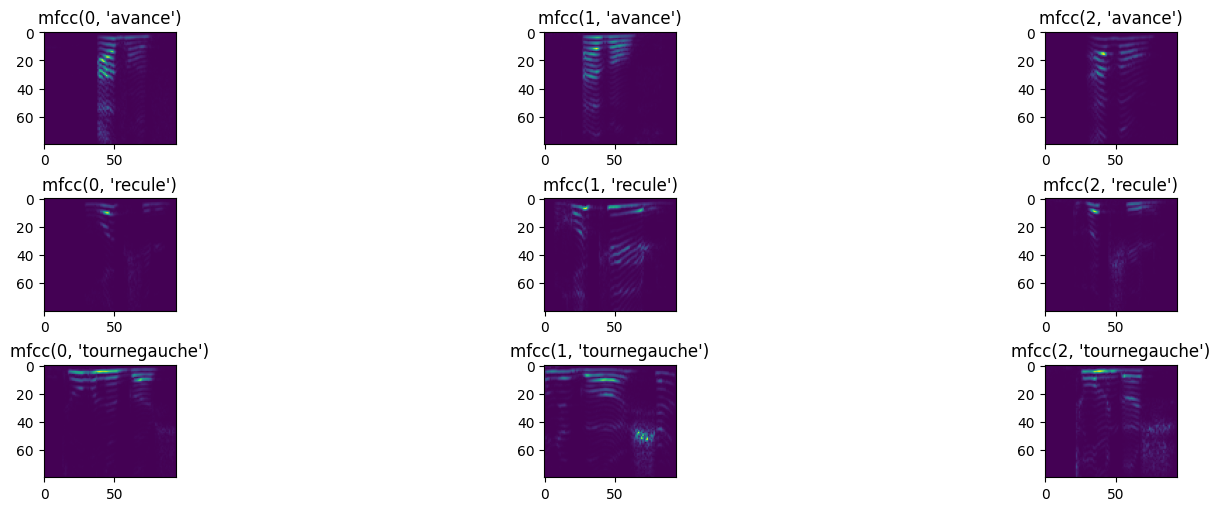

In [55]:
nperseg = 400 # nombre d'échantillon d'un fenêtre auquel on applique sfft

# delta w * deltat >= 1/2 (égalité d'Heseinberg) : plus on est précis au temps, moins on est précis en fréquence

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(15,5))
for i,word in enumerate(words):
    for instance in range(3):

        record = X[(y==i) & (genres == 'F')][instance]
        f, t, Zxx = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        axs[i,instance].imshow(np.absolute(Zxx[:80]))
        axs[i,instance].set_title(f'mfcc{instance,word}')

        
print(Zxx.shape)
plt.show()

#### Now we will build sklearn transformers to extract features

Create a class STFT in the same spirit as FFT. 
Add a first argument to choose between returning different statistics (mean, quantile, max...) along time such that each signal. Add a second argument that gives the maximum frequency index 

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin

In [57]:
class FFT(BaseEstimator, TransformerMixin):
    #
    def __init__(self, idx_frequence_max=None):
        self.idx_frequence_max = idx_frequence_max
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Perform arbitary transformation        
        return np.absolute(fft(X)[:self.idx_frequence_max])

In [58]:
class STFT(BaseEstimator, TransformerMixin):
    # BaseEstimator : classe hérité, sert après quand on 
    def __init__(self, statistic, nperseg, idx_frequence_max=None):
        self.idx_frequence_max = idx_frequence_max
        self.statistic = statistic
        self.nperseg = nperseg
        
    def fit(self, X, y=None):
        return self #on n'a pas besoin de s'adapter aux données
    
    def transform(self, X, y=None):
        f, t, Zxx = signal.stft(X, fs=fs, window='hann', nperseg=self.nperseg, noverlap=None)
        return np.absolute(self.statistic(Zxx, axis=2)[:,:self.idx_frequence_max])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
np.random.seed(seed=42)

In [60]:
X_test.shape

(17, 18522)

# Partie I : Sélection de modèles et pénalisation

### 1. Multiclass regression


Apply a **multiclass regression** model.

We model the probabilities by the following form :

$$
\mathbb{P}(Y_i = j) = \frac { \exp^{-\beta_j^{T} X_i } } {\sum_{\ell = 1}^{K-1} \exp^{-\beta_\ell^{T} X_i }}, 
$$
For all $j$ in $\{ 1,2, \dots , K-1 \}$.

### Objective

Try to apply a logistic regression with **Leave one out Cross validation** on :

1. The first PCA components of FFT (try multiple "n_compenents")
2. Different statistics and maximum frequency of the STFT
3. The same as before with scaling

In each situations try different regularization coefficient C.

To simplify use the **pipeline** function of sklearn. You can also use the function **GridSearchCV** with cv = X.shape[0] to vary the parameters of preprocessing and logistic regression. You can acess to all results with "cv_results_"



In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut

In [17]:
pipe = Pipeline([('fft', FFT()), 
                 ('scaler', StandardScaler()), 
                 ('pca', PCA()), 
                 ('logistic', LogisticRegression(max_iter=10000, solver='saga', penalty = 'l1'))])
param_grid = {
    "pca__n_components": [45,300],
    "logistic__C": [100,12323.3],
  #  "logistic__C": [10**-2,10**-1,10**1,10**2,10**3],
# "logistic__solver": ['lbfgs', 'saga', 'sag', 'newton-cg'],
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=LeaveOneOut(), verbose = 3) #int(X.shape[0]))
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 54 folds for each of 4 candidates, totalling 216 fits
Best parameter (CV score=0.722):
{'logistic__C': 100, 'pca__n_components': 45}


In [18]:
pipe = Pipeline([('stft', STFT(statistic=np.mean, nperseg=120, idx_frequence_max=45)), 
                 ('scaler', StandardScaler()), 
                 ('pca', PCA()), 
                 ('logistic', LogisticRegression( max_iter=10000, penalty='l2' ))])
param_grid = {
#    "logistic__C": np.logspace(-6,6,20),
    "pca__n_components": np.arange(10,45),
   "logistic__solver": ['lbfgs'],
    "logistic__C": np.linspace(1.2,1.7,10)
#     "logistic__solver": ['lbfgs', 'saga', 'sag'] #, 'newton-cg'],
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=LeaveOneOut(), verbose=1 ) #int(X.shape[0]))
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 54 folds for each of 350 candidates, totalling 18900 fits
Best parameter (CV score=0.796):
{'logistic__C': 1.2, 'logistic__solver': 'lbfgs', 'pca__n_components': 20}


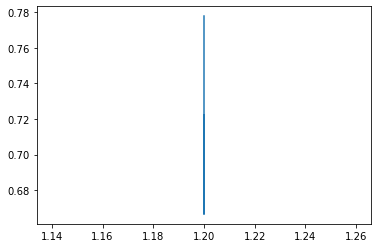

In [19]:
tabx=[]
taby=[]
for i in range(10):
    tabx.append(search.cv_results_['mean_test_score'][i])
    taby.append((search.cv_results_['params'][i]['logistic__C']))
plt.plot(taby,tabx)

###  Evaluation des résultats 

Evaluer le résultat par matrice de confusion et pourcentage de bonne classification.

*Conseil :* Pensez à mettre une fonction pour afficher la matrice de confusion

In [20]:
# Evaluation des résultats par matrices de confusion 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Partie II : Classification par méthodes à noyau

**Rappel** Les méthodes à noyau consistent à plonger les données dans un espace de dimension de Hilbert $\mathcal{H}$ ou les donnés pourront être séparé linéairement. 

**Theorème de Représentation :** La solution du problème de séparation en dimension infinie est contenue dans un sous espace vectoriel de dimension finie de $\mathcal{H}$ 

### 1. Réaliser une classification par SVM à noyau

    1) Varier le noyau
    2) Varier le paramètre de régularisation.


In [21]:
from sklearn.svm import SVC

pipe2 = Pipeline([('fft', FFT()), 
                 ('scaler', StandardScaler()), 
                 ('pca', PCA()), 
                 ('svc', SVC(gamma='scale'))])
param_grid = {
    "pca__n_components": [40],
    "svc__kernel": ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
}

search = GridSearchCV(pipe2, param_grid, n_jobs=-1, cv=LeaveOneOut(), verbose = 3) #int(X.shape[0]))
search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 54 folds for each of 5 candidates, totalling 270 fits
Best parameter (CV score=0.722):
{'pca__n_components': 40, 'svc__kernel': 'linear'}


In [22]:
pipe = Pipeline([('stft', STFT(statistic=np.mean, nperseg=120, idx_frequence_max=45)), 
                 ('scaler', StandardScaler()), 
                 ('svc', SVC(gamma='scale'))])
param_grid = {
    "svc__kernel": ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=LeaveOneOut(), verbose=1 ) #int(X.shape[0]))
hehe = search.fit(X, y)


print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 54 folds for each of 5 candidates, totalling 270 fits
Best parameter (CV score=0.833):
{'svc__kernel': 'linear'}


In [23]:
pipe = Pipeline([('stft', STFT(statistic=np.mean, nperseg=120, idx_frequence_max=45)), 
                 ('scaler', StandardScaler()), 
                 ('svc', SVC(gamma='scale'))])
param_grid = {
    "svc__kernel": ['linear'],
    "svc__C": np.linspace(1e-4, 1, 10)
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=LeaveOneOut(), verbose=1 ) #int(X.shape[0]))
hehe = search.fit(X, y)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 54 folds for each of 10 candidates, totalling 540 fits
Best parameter (CV score=0.870):
{'svc__C': 0.6667000000000001, 'svc__kernel': 'linear'}


(-15.0, 2.5)

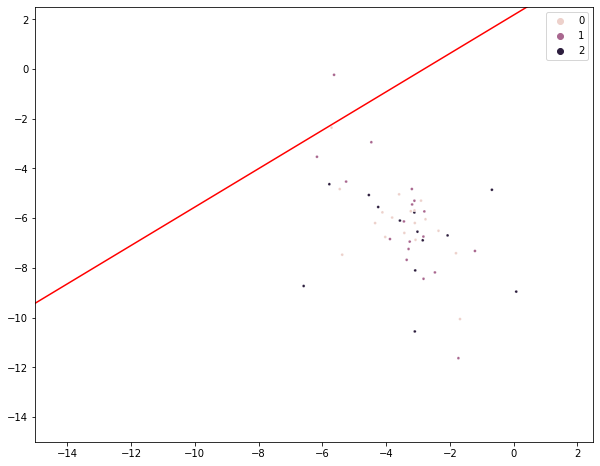

In [24]:
import seaborn as sns
plt.figure(figsize=(10, 8))
# Plotting our two-features-space
X_scale = StandardScaler().fit_transform(X)
X_acp = PCA(n_components=2).fit_transform(X_scale)
sns.scatterplot(x=X_acp[:, 0], 
                y=X_acp[:, 1] , hue=y, s=8)
# Constructing a hyperplane using a formula.
w = hehe.best_estimator_.named_steps['svc'].coef_[0]           # w consists of 2 elements
b = hehe.best_estimator_.named_steps['svc'].intercept_[0]      # b consists of 1 element
x_points = np.linspace(-40, 1)    # generating x-points from -1 to 1
y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points
# Plotting a red hyperplane
plt.plot(x_points, y_points, c='r');
plt.xlim(-15,2.5)
plt.ylim(-15,2.5)

In [25]:
X_scale

array([[-6.46079228e-01, -1.13139803e+00, -2.17226490e+00, ...,
         1.50865258e-01,  2.87843029e-01,  1.82721704e-01],
       [ 1.63345094e-02, -8.21335062e-02, -5.43148386e-01, ...,
         9.95560750e-02,  8.62734636e-03,  1.36522647e-03],
       [-1.51610166e-01, -1.63365787e-01, -4.32236091e-01, ...,
         2.23097836e-01,  1.12237767e-01,  3.79930560e-02],
       ...,
       [ 1.60806656e-01,  3.91426581e-02, -4.81977247e-01, ...,
         2.38368372e-01,  8.02450489e-02,  9.14891238e-02],
       [ 5.29930388e-01,  6.04001473e-01,  6.15603098e-01, ...,
         3.32922273e-01, -5.51822460e-01, -4.07457354e-01],
       [-4.86459545e-01, -5.47792245e-01, -1.18703261e+00, ...,
         3.06842069e-01,  2.65330207e-01,  1.85306407e-01]])

In [26]:
X

array([[-1.56092015e-03, -1.87590625e-03, -1.86939910e-03, ...,
         5.99134830e-04,  2.30481848e-03,  1.69108540e-03],
       [-2.18155124e-04, -2.84662907e-04, -4.53959859e-04, ...,
         1.27560023e-04,  1.12567977e-04,  2.72698497e-04],
       [-5.58592263e-04, -4.07854270e-04, -3.57594981e-04, ...,
         1.26301334e-03,  9.26060951e-04,  5.59164328e-04],
       ...,
       [ 7.47013401e-05, -1.00743709e-04, -4.00812016e-04, ...,
         1.40336249e-03,  6.74871437e-04,  9.77556454e-04],
       [ 8.22944334e-04,  7.55882822e-04,  5.52808109e-04, ...,
         2.27239286e-03, -4.28778073e-03, -2.92469817e-03],
       [-1.23735843e-03, -9.90849338e-04, -1.01339130e-03, ...,
         2.03269371e-03,  2.12805998e-03,  1.71130034e-03]])

### Approche non supervisée :  Classification spectrale 

 On peut aussi transposer à l'espace de Hilbert $\mathcal{H}$ des algos classiques de $\mathbb{R}^d$ comme la Classification spectrale.
 
 Réaliser une classification spectrale non supervisée sur les données. Interpréter les résultats 

In [26]:
from sklearn.cluster import SpectralClustering

In [27]:
pred = hehe.predict(BaseTest)
heatmap(LabelTest, pred)

NameError: name 'BaseTest' is not defined

# Partie III : Apprentissage par ensemble

## 1. Bootstrap Aggregation : Bagging

Boostrap consists in creating multiple data sets as follows. Suppose our
original data set consists of $N$ data points $X = \{x_1,..., x_N \}$. We can create a new
data set $X_B$ by drawing $N$ points at random from X, with replacement, so that some
points in $X$ may be replicated in $X_B$, whereas other points in $X$ may be absent from
$X_B$. This process can be repeated $M$ times to generate $M$ data sets each of size $N$ and
each obtained by sampling from the original data set $X$.

Consider a binary classification problem in which we are trying to predict the class, and suppose we generate $M$ bootstrap data sets and then use each to train a separate copy $y_m(x)$ of a classifier where $m = 1,...,M$. The committee prediction is given by voting with all $M$ models.

1. First you will transform $y$ in $y^1$ as follow
if $y = 1$, then $y^1 = 1$
if $y = 0$ or $y = 2$, then $y^1 = 0$
Now we can apply binary classification

2. Code from scratch the Bagging of Decision trees with *max_depth = 2* only and compare the accuracy of the bagging model with the mean accuracy of the models and conclude. (the bootstrap is done on the training set with np.random.choice, and use $M=100$)

3. Apply Random Forest on the initial classification problem (3 classes) and adjust the hyperparameters. Is random Forest a Bagging model?

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [29]:
y

array([2, 2, 0, 1, 1, 2, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 1, 1, 1, 1, 2, 0,
       1, 1, 0, 0, 2, 1, 0, 0, 0, 2, 2, 1, 1, 1, 0, 0, 2, 2, 2, 2, 2, 0,
       0, 1, 0, 2, 1, 2, 1, 1, 2, 1])

In [105]:
### 1. create y1
y1 = np.array(1*(y==1))
print(y1)

[0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1]


In [106]:
### 2. 
X_train, X_test, y_train, y_test = train_test_split(X,y1,test_size=0.4, random_state=42)
np.random.seed(seed=42)

In [107]:
M = 100
N = X_train.shape[0]
trees=[]

predict_result = np.zeros((X_test.shape[0], M))
for m in range(M):
    index_model = np.random.randint(low=0, high=N, size=(N,))
    yB = y_train[index_model]
    XB = X_train[index_model]
    tree = Pipeline([('stft', STFT(statistic=np.mean, nperseg=120, idx_frequence_max=45)), 
                 ('scaler', StandardScaler()), 
                 ('trees', DecisionTreeClassifier(max_depth=2))])
    tree.fit(XB, yB)
    trees.append(tree)
    predict_result[:,m] = tree.predict(X_test)

    

In [108]:
com_result = []
for n in range(X_test.shape[0]):
    values, counts = np.unique(predict_result[n,:], return_counts=True)
    ind = np.argmax(counts)
    com_result.append(values[ind])

In [109]:
com_result = np.array(com_result, dtype=int)

In [110]:
com_result

array([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0])

In [111]:
y_test

array([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0])

In [112]:
#comparaison accuracy

In [116]:
acc_modele = []
acc_com = 100*sum(com_result == y_test)/len(y_test)
for m in range(M):
    acc_modele.append(100*sum(predict_result[:,m] == y_test)/len(y_test))

In [117]:
print(1/M*np.sum(acc_modele))

66.68181818181819


In [115]:
print(acc_com)

77.27272727272727


In [41]:
#3 .# Fitting Random Forest Classification to the Training set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4, random_state=42)
np.random.seed(seed=42)

from sklearn.ensemble import RandomForestClassifier

ranforest = Pipeline([('stft', STFT(statistic=np.mean, nperseg=120, idx_frequence_max=45)), 
                 ('scaler', StandardScaler()), 
                 ('forest', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42))])
ranforest.fit(X_train, y_train)

Pipeline(steps=[('stft',
                 STFT(idx_frequence_max=45, nperseg=120,
                      statistic=<function mean at 0x7fed3c0a8e50>)),
                ('scaler', StandardScaler()),
                ('forest',
                 RandomForestClassifier(criterion='entropy', n_estimators=10,
                                        random_state=42))])

In [42]:
predict_ranforest = ranforest.predict(X_test)

In [43]:
print("accuracy", 100*np.sum(predict_ranforest == y_test)/len(y_test))

accuracy 59.09090909090909


## 2. Adaptative boosting : AdaBoost

Here is the algorithm Adaboost

1. Initialize the data weighting coefficients ${w_n}$ by setting $w_n^{(1)} = 1/N$ for $n = 1,...,N$.
2. For $m = 1,...,M$:
    
    **(a)** Fit a classifier $y_m(x)$ to the training data by minimizing the weighted
error function
    
    $J_m = \sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}$

    where $I(y_m(x)\neq t_n)$ is the indicator function and equals $1$ when $y_m(x_n) 	\neq t_n$ and $0$ otherwise

    **(b)** Evaluate the quantities

    $\epsilon_m = \frac{\sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}}{\sum_{n=1}^N{w_n^{(m)}}}$

    and then use these to evaluate

    $\alpha_m = \textit{ln}\left({\frac{1-\epsilon_m}{\epsilon_m}}\right)$

    **(c)** Update the data weighting coefficients
    
    $w_n^{(m+1)} = w_n^{(m)} \textit{exp}\left({\alpha_m I(y_m(x_n) \neq t_n)}\right)$

3. Make predictions using the final model, which is given by

    $Y_M(x) = \text{sign}\left(\sum_{m=1}^M {\alpha_m y_m(x)}\right)$


**Question 1 :** Code from scratch the Adaboost algorithm in the same configuration as Bagging in the previous section. Use the sklearn decision tree classifier and its argument *sample_weight*. Compare its performances with Bagging.

In [118]:
from sklearn.ensemble import AdaBoostClassifier

In [119]:
y2 = np.array(1*(y==1))
y2[y2==0] = -1
print(y2)

[-1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1  1 -1 -1  1  1
 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
  1 -1  1  1 -1  1]


In [120]:
X2 = STFT(statistic=np.mean, nperseg=120, idx_frequence_max=45).transform(X)
X2 = StandardScaler().fit_transform(X2)
X_train, X_test, y_train, y_test = train_test_split(X2,y2,test_size=0.4, random_state=42)
np.random.seed(seed=42)

In [133]:
N = X_train.shape[0]
w0 = np.array([1/N]*N)
M = 1000
predict_result = np.zeros((N, M))
alpha = np.zeros(M)
Trees = []

for m in range(M):
    tree =  DecisionTreeClassifier(max_depth=1)
    tree.fit(X_train, y_train, sample_weight=w0)
    Trees.append(tree)
    predict_result[:,m] = tree.predict(X_train)
    I = 1*(predict_result[:,m]!=y_train)
    eps = np.dot(w0, I)/np.sum(w0)
    alpha[m]=np.log((1-eps)/eps)
    w0 = w0*np.exp(alpha[m]*I)

Y_M = np.zeros(N)
for m in range(M):
    Y_M += alpha[m]*predict_result[:, m]
Y_M = np.sign(Y_M)

In [134]:
print("Accuracy of training database", 100*np.sum(1*(Y_M == y_train)/len(Y_M)))

Accuracy of training database 100.0


In [135]:
Y_test_M = np.zeros(X_test.shape[0])

for m in range(M):
    Y_test_M += alpha[m]*Trees[m].predict(X_test)
    
Y_test_M = np.sign(Y_test_M)

In [136]:
100*np.sum(1*Y_test_M == y_test)/len(Y_test_M)

72.72727272727273

**Question 2 :** 
With sklearn library, apply adaboost with decision tree (*max_depth=2*) on the 3-class classification problem. Find good parameters with the leave one out cross validation. Do the same thing with Gradient bossting.
If you have the time, you can test with XGBoost.


In [137]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4, random_state=42)
np.random.seed(seed=42)


In [146]:
pipe = Pipeline([('stft', STFT(statistic=np.mean, nperseg=120, idx_frequence_max=45)), 
                 ('scaler', StandardScaler()), 
                 ('forest', RandomForestClassifier(random_state = 42))])
param_grid = {
    "forest__n_estimators": np.arange(10,100),
    "forest__criterion": ["gini", "entropy", "log_loss"],
    "forest__max_depth": np.arange(2,9)
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=LeaveOneOut(), verbose=1 ) #int(X.shape[0]))
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 32 folds for each of 1890 candidates, totalling 60480 fits
Best parameter (CV score=0.781):
{'forest__criterion': 'entropy', 'forest__max_depth': 6, 'forest__n_estimators': 19}


In [147]:
print("Accuracy: ", 100*np.sum(1*(search.predict(X_test) == y_test))/len(y_test))

Accuracy:  63.63636363636363


In [157]:
pipe = Pipeline([('stft', STFT(statistic=np.mean, nperseg=120, idx_frequence_max=45)), 
                 ('scaler', StandardScaler()), 
                 ('adab', AdaBoostClassifier(random_state = 42))])
param_grid = {
    "adab__estimator" : [DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)],
    "adab__n_estimators": np.arange(10,100)
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=LeaveOneOut(), verbose=1 ) #int(X.shape[0]))
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 32 folds for each of 180 candidates, totalling 5760 fits
Best parameter (CV score=0.625):
{'adab__estimator': DecisionTreeClassifier(max_depth=2), 'adab__n_estimators': 21}


## 2. Gradient Boosting

Le Gradient Boosting permet l'optimisation de fonctions de perte différentiables arbitraires. Il permet d'optimiser la fonction de perte de l'apprenant précédent en ajoutant un nouveau modèle adaptatif qui combine des apprenants faibles.

Etudier sur la fonction de perte et le taux d'apprentissage.

In [166]:
from numba.core.types.containers import ListTypeIterableType
from sklearn.ensemble import GradientBoostingClassifier

pipe = Pipeline([('stft', STFT(statistic=np.max, nperseg=120, idx_frequence_max=25)), 
                 ('scaler', StandardScaler()), 
                 ('grad_boost', GradientBoostingClassifier(random_state = 42))])
param_grid = {
    "grad_boost__n_estimators": [1000],
    "grad_boost__criterion": ["squared_error"],
    "grad_boost__max_depth": [1],
    "grad_boost__loss": ["log_loss"]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=LeaveOneOut(), verbose=1 ) #int(X.shape[0]))
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 32 folds for each of 1 candidates, totalling 32 fits
Best parameter (CV score=0.625):
{'grad_boost__criterion': 'squared_error', 'grad_boost__loss': 'log_loss', 'grad_boost__max_depth': 1, 'grad_boost__n_estimators': 1000}


### Evaluation de la classification

Utiliser la validation croisée pour évaluer les résultats 

In [22]:
from sklearn.model_selection import cross_val_score

# Partie IV : Neural Network with pytorch

Below we create torch tensor with the shape $(N,B,F)$, where
    
$N$ is the number of recordings in the set (train/test)

$B$ the size of batch, we choose $B=1$ because the dataset is really small

$F$ is the number of features

The tensors are converted to float type

The train set and test set constitute 50% of the initial dataset

**Transform X with your preprocessing**

In [29]:
import torch

In [64]:
X = STFT(statistic=np.mean, nperseg=120, idx_frequence_max=45).transform(X_raw)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

scaler = StandardScaler()
# pas X = StandardScaler().fit_transform(X) car on transmet de l'information dans X_test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [65]:
X_train = torch.tensor(X_train).reshape((X_train.shape[0], 1, -1)).float()
X_test = torch.tensor(X_test).reshape((X_test.shape[0], 1, -1)).float()

y_train = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=- 1).reshape((X_train.shape[0], 1, -1)).float()
y_test = torch.nn.functional.one_hot(torch.tensor(y_test), num_classes=- 1).reshape((X_test.shape[0], 1, -1)).float()

**Question 1:** : Create a model class (descending from torch.nn.Module). In a first time choose the appropriate architecture and the appropriate loss (the loss appear later) to reproduce logistic regression
​
Usually a FNN is a succession of blocks (linear -> ReLU). Finally the networks transforms the initial vector into the output $\hat{y} \in \mathbb{R}^3, \hat{y}=(\mathbb{P}(y=0|x),\mathbb{P}(y=1|x),\mathbb{P}(y=2|x))$ where $y$ is the word we want to predict and $x \in \mathbb{R}^{18522}$ is the accoustic signal

In [183]:
class NNClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            ### Define here the succession of torch.nn modules that will constitutes your network
            ### building blocks are torch.nn.ReLU, torch.nn.Linear
            torch.nn.Linear(45, 3)
        )

    def forward(self, xb):
        ### the forward method will be called each time you will write model(x). 
        ### It's equivalent to the function predict of sklearn
        return torch.nn.functional.softmax(self.network(xb), dim=-1)

In [273]:
def train_model(model, optimizer, loss, num_epochs):
    result = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        train_acc = []
        for i in range(X_train.shape[0]):
           # code the training step (compute loss -> optimization step -> save the loss)
            optimizer.zero_grad()
            y_step = model(X_train[i])

            step_loss = loss(y_step, y_train[i])
            train_losses.append(step_loss)
            train_acc.append((y_step.argmax() == y_train[i].argmax()).double())

            step_loss.backward()
            optimizer.step()

        model.eval()
        test_losses = []
        test_acc = []
        for i in range(X_test.shape[0]):
            # code the eval step  (compute loss -> save the loss)
            y_step = model(X_test[i])
            test_losses.append(loss(y_step, y_test[i]))
            test_acc.append((y_step.argmax() == y_test[i].argmax()).double())

        result['train_loss'].append(torch.stack(train_losses).mean().item())
        result['test_loss'].append(torch.stack(test_losses).mean().item())

        result['train_acc'].append(torch.stack(train_acc).mean().item())
        result['test_acc'].append(torch.stack(test_acc).mean().item())

    return result

In [274]:
model = NNClassification()
num_epochs = 200

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr)
loss = torch.nn.CrossEntropyLoss()

nn_result = train_model(model, optimizer, loss, num_epochs)

**Question 2:** Plot the train and test loss. What do you observe?

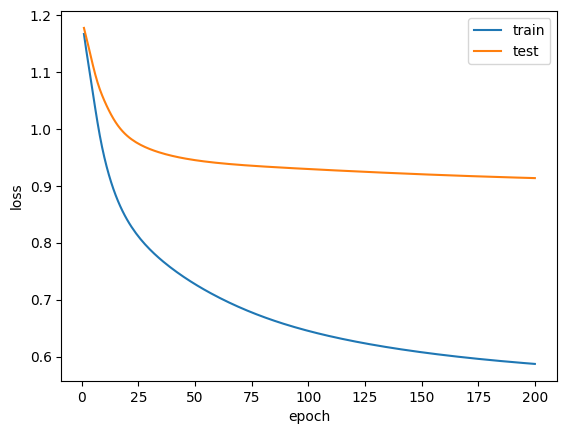

In [275]:
x_epoch = range(1, num_epochs+1)
plt.plot(x_epoch, nn_result['train_loss'], label='train')
plt.plot(x_epoch, nn_result['test_loss'], label='test')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

**Question 3 :** Compute the accuracy.

In [276]:
train_accuracy = (sum(model(X_train).argmax(2) == y_train.argmax(2)) / y_train.shape[0]).item()
print(f'train accuracy = {train_accuracy:.4f}')
test_accuracy = (sum(model(X_test).argmax(2) == y_test.argmax(2)) / y_test.shape[0]).item()
print(f'test accuracy = {test_accuracy:.4f}')

train accuracy = 1.0000
test accuracy = 0.6667


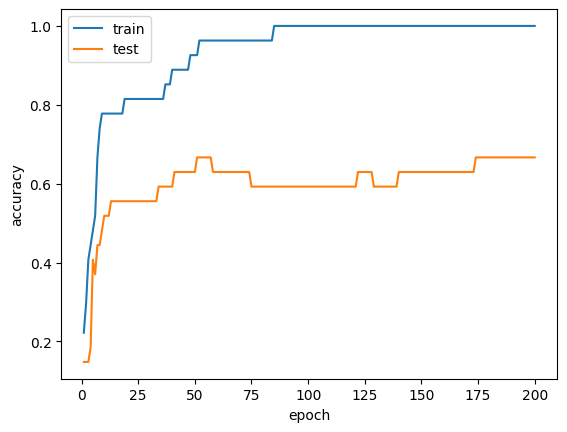

In [278]:
plt.plot(x_epoch, nn_result['train_acc'], label='train')
plt.plot(x_epoch, nn_result['test_acc'], label='test')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

**Question 4:** If you encounter overfitting try to regularize your model with Dropout and/or L2/L1 Regularization

In [307]:
class NNRegClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            ### Define here the succession of torch.nn modules that will constitutes your network
            ### building blocks are torch.nn.ReLU, torch.nn.Linear
            torch.nn.Dropout(0.25),
            torch.nn.Linear(45, 3),
        )

    def forward(self, xb):
        ### the forward method will be called each time you will write model(x). 
        ### It's equivalent to the function predict of sklearn
        return torch.nn.functional.softmax(self.network(xb), dim=-1)

In [1]:
model = NNClassification()
num_epochs = 200

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-5)
loss = torch.nn.CrossEntropyLoss()

nn_reg_result = train_model(model, optimizer, loss, num_epochs)

x_epoch = range(1, num_epochs+1)
plt.plot(x_epoch, nn_reg_result['train_loss'], label='train')
plt.plot(x_epoch, nn_reg_result['test_loss'], label='test')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(x_epoch, nn_reg_result['train_acc'], label='train')
plt.plot(x_epoch, nn_reg_result['test_acc'], label='test')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

train_accuracy = (sum(model(X_train).argmax(2) == y_train.argmax(2)) / y_train.shape[0]).item()
print(f'train accuracy = {train_accuracy:.4f}')
test_accuracy = (sum(model(X_test).argmax(2) == y_test.argmax(2)) / y_test.shape[0]).item()
print(f'test accuracy = {test_accuracy:.4f}')

NameError: name 'NNClassification' is not defined

**Question 5(Bonus)** : Create a CNN that takes in input the accoustic signal without preprocessing

In [ ]:
class CNNClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            ### Define here the succession of torch.nn modules that will constitutes your network
            ### building blocks are torch.nn.ReLU, torch.nn.Linear
            torch.nn.Conv2d(45, 3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(),
        )

    def forward(self, xb):
        ### the forward method will be called each time you will write model(x). 
        ### It's equivalent to the function predict of sklearn
        return torch.nn.functional.softmax(self.network(xb), dim=-1)

# Partie V : Votre étude 




Réalisez votre propre étude par binôme :
- en modifiant les bases de test et/ou d'apprentissage c'est-à-dire en créant  votre propre base d'apprentissage et votre base de test à partir du corpus et des voix et bruits que vous aurez enregistrés
- en rajoutant davantage de classes (jusqu'à 13 ordres vocaux disponibles) 
- en utilisant d'autres méthodes de réduction de dimension des MFCC (ACP,t-SNE)
le tout en testant les différentes approches et en interprétant les résultats, à synthétiser sur un rapport en pdf. 


**Paramètres pour enregistrements audio de vos voix perso:**

16 KHz, mono, 16 bits, format *.wav*